# TC3006B
## Deep Learning
# Script para elegir 300 imágenes al azar del bucket de s3 y obtener su meta-data

### Preparations for the script
You need to install the aws cli in order for the script to work: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

Once installed, run the command 

*aws configure*

It will ask you for some keys that are hidden for security purposes. For the region put us-east-1 and for output leave it as default "json".

And for the libraries just run 

*pip install -r requirements.txt*

If everything is configured correctly you may run now the script.

## Creación del csv

### Imports

In [22]:
import boto3
import csv
import random
from io import BytesIO
from PIL import Image, ImageStat
from concurrent.futures import ThreadPoolExecutor, as_completed

### Variables globales

In [23]:
# Configuración
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket
OUTPUT_CSV = 's3_image_metadata_advanced_with_histograms.csv'
MAX_IMAGES = 150  # Número máximo de imágenes a procesar
MAX_WORKERS = 10  # Número de hilos para procesamiento paralelo

### Creamos una lista con todos los objetos de la bucket

In [24]:
def list_all_objects(s3_client, bucket):
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket)
    all_objects = []
    for page in page_iterator:
        contents = page.get('Contents', [])
        all_objects.extend(contents)
    return all_objects

### Procesamos cada imagen obteniendo la meta-data de la misma, witdh, height, luminosity, contrast e histogramas rgb

In [25]:
def process_object(s3_client, bucket, obj):
    key = obj['Key']
    last_modified = obj['LastModified']
    size = obj['Size']
    etag = obj['ETag']
    storage_class = obj.get('StorageClass', 'STANDARD')
    owner = obj.get('Owner', {}).get('DisplayName', 'Unknown')
    content_type = obj.get('ContentType', 'Unknown')
    
    # Inicializar variables para características avanzadas
    width, height = None, None
    luminosity, contrast = None, None
    histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    try:
        # Descargar la imagen en memoria
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Asegurar que la imagen esté en RGB
        
        # Obtener dimensiones de la imagen
        width, height = image.size
        
        # Convertir la imagen a escala de grises para calcular luminosidad y contraste
        grayscale_image = image.convert('L')
        stat = ImageStat.Stat(grayscale_image)
        
        # Calcular la luminosidad (media de los valores de píxel)
        luminosity = stat.mean[0]
        
        # Calcular el contraste (desviación estándar de los valores de píxel)
        contrast = stat.stddev[0]
        
        # Calcular histogramas para cada canal
        histogram = image.histogram()
        # Histograma tiene 256 valores por canal (R, G, B)
        histogram_red = histogram[0:256]
        histogram_green = histogram[256:512]
        histogram_blue = histogram[512:768]
        
    except Exception as e:
        print(f"Error procesando {key}: {e}")
        # Asignar valores predeterminados o continuar según sea necesario
        width, height = None, None
        luminosity, contrast = None, None
        histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    # Preparar los histogramas como cadenas de texto
    histogram_red_str = ';'.join(map(str, histogram_red)) if histogram_red else ''
    histogram_green_str = ';'.join(map(str, histogram_green)) if histogram_green else ''
    histogram_blue_str = ';'.join(map(str, histogram_blue)) if histogram_blue else ''
    
    Url = f"https://{bucket}.s3.amazonaws.com/{key}"
    
    return [
        key, Url, last_modified, size, etag, 
        storage_class, owner, content_type,
        width, height, luminosity, contrast,
        histogram_red_str, histogram_green_str, histogram_blue_str
    ]

### Creamos la funcion main y escribimos en el meta-data

In [26]:
def main():
    # Inicializar el cliente de S3
    s3 = boto3.client('s3')
    
    # Listar todos los objetos en el bucket
    print("Listando objetos en el bucket...")
    all_objects = list_all_objects(s3, BUCKET_NAME)
    total_objects = len(all_objects)
    print(f"Total de objetos en el bucket: {total_objects}")
    
    if total_objects == 0:
        print("No se encontraron objetos en el bucket.")
        return
    
    # Elegir 300 objetos al azar si hay suficientes, si no, toma todos
    sample_size = min(total_objects, MAX_IMAGES)
    sampled_objects = random.sample(all_objects, sample_size)
    print(f"Seleccionando {sample_size} objetos al azar para procesar...")
    
    # Definir los encabezados del CSV
    headers = [
        'Key', 'Url', 'LastModified', 'Size', 'ETag', 
        'StorageClass', 'Owner', 'ContentType',
        'Width', 'Height', 'Luminosity', 'Contrast',
        'Histogram_Red', 'Histogram_Green', 'Histogram_Blue'
    ]
    
    # Procesar los objetos en paralelo para mejorar el rendimiento
    print("Procesando objetos y extrayendo metadata...")
    processed_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Enviar tareas al pool de hilos
        futures = {executor.submit(process_object, s3, BUCKET_NAME, obj): obj for obj in sampled_objects}
        for future in as_completed(futures):
            data = future.result()
            processed_data.append(data)
    
    # Escribir los datos en el CSV
    print(f"Escribiendo metadata en el archivo CSV: {OUTPUT_CSV}")
    with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Escribir encabezados
        writer.writerows(processed_data)  # Escribir filas de datos
    
    print(f"CSV creado con {sample_size} registros de metadata avanzados seleccionados al azar.")


### Corremos el programa

In [27]:
if __name__ == "__main__":
    main()

Listando objetos en el bucket...
Total de objetos en el bucket: 2189
Seleccionando 150 objetos al azar para procesar...
Procesando objetos y extrayendo metadata...
Escribiendo metadata en el archivo CSV: s3_image_metadata_advanced_with_histograms.csv
CSV creado con 150 registros de metadata avanzados seleccionados al azar.


## Creamos gráficas para visualización de la información en el csv

### Imports

In [28]:
# Importar las bibliotecas necesarias
import pandas as pd
import seaborn as sns
from PIL import Image

# Configurar estilos para las gráficas
sns.set(style="whitegrid")
%matplotlib inline


### Pasamor el csv a pandas

In [43]:
# Cargar el CSV en un DataFrame de pandas
df = pd.read_csv('s3_image_metadata_advanced_with_histograms.csv')


### Visualizamos csv

In [30]:
df

,Key,Url,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,train/4/2024-05-19-18-30-03_jpg.rf.646ff59c7e7...,https://caetec-vacas.s3.amazonaws.com/train/4/...,2024-10-14 18:11:54+00:00,204827,"""d4ffae9fe45a873b82a43e9cd278eb78""",STANDARD,Unknown,Unknown,1920,1080,73.788621,56.355836,2138;1018;1453;2208;3814;5848;8521;9400;10353;...,3;3;15;35;130;533;1567;3520;4868;8587;13703;15...,923;1672;3368;6995;9186;12855;11211;11580;1299...
1,test/6/2024-05-03-15-50-03_jpg.rf.8a98a14e8e77...,https://caetec-vacas.s3.amazonaws.com/test/6/2...,2024-10-14 18:22:24+00:00,203846,"""7280afd78362bf9d045c62a8f3b7a975""",STANDARD,Unknown,Unknown,1920,1080,81.979277,70.834687,950;814;1763;8955;12996;21609;34593;38032;4024...,4;13;25;270;643;6094;4982;6239;9668;19277;3875...,15484;13887;26048;32362;40547;51336;49491;5724...
2,validation/3/2024-05-18-22-55-03_jpg.rf.6fec1c...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:18:04+00:00,31639,"""a90fc01011b570ed3c5761a15bcea393""",STANDARD,Unknown,Unknown,640,640,12.094282,14.093737,8037;29186;31673;32290;22544;17109;15089;12888...,27601;51472;45759;31472;23188;18778;16160;1429...,116467;63323;41273;33392;26607;21908;17542;135...
3,validation/3/2024-05-19-08-40-03_jpg.rf.738246...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:18:07+00:00,65359,"""49949cc7f6ead75bc1c214ff7b11192c""",STANDARD,Unknown,Unknown,640,640,105.081353,54.546120,0;0;4;3;10;8;19;29;30;34;47;52;74;119;222;345;...,0;0;0;0;0;0;1;0;0;0;0;0;0;2;1;3;8;20;44;59;83;...,7;1;1;1;1;3;4;2;6;14;4;5;15;7;14;23;36;66;100;...
4,validation/4/2024-05-18-11-45-03_jpg.rf.d7f6fa...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:17:06+00:00,58350,"""9ae68da3315797330ccc55c6f789f48d""",STANDARD,Unknown,Unknown,640,640,131.858901,54.203646,0;0;0;0;0;0;0;0;0;1;1;0;0;0;2;0;0;1;0;1;0;1;1;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,validation/3/2024-05-18-05-10-03_jpg.rf.fa6926...,https://caetec-vacas.s3.amazonaws.com/validati...,2024-10-14 18:17:46+00:00,27610,"""d426f07a1749a35c277f1a329cd2b5dc""",STANDARD,Unknown,Unknown,640,640,10.502092,17.397152,83124;55624;25352;20532;15227;12316;11057;1031...,92685;66543;35076;24873;20204;16835;13917;1125...,157370;71300;35154;25758;19364;15911;12610;103...
146,train/3/2024-05-22-07-30-03_jpg.rf.ee352a8c1aa...,https://caetec-vacas.s3.amazonaws.com/train/3/...,2024-10-14 18:10:49+00:00,250361,"""0db4b6cd2ca77d3ec5571fa3f41c1905""",STANDARD,Unknown,Unknown,1920,1080,155.026147,43.224688,0;0;0;0;0;3;15;19;46;57;64;93;80;88;87;101;75;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
147,test/3/2024-05-03-23-50-03_jpg.rf.420e5c684260...,https://caetec-vacas.s3.amazonaws.com/test/3/2...,2024-10-14 18:25:51+00:00,133443,"""4d3a22293662ea656635db8a539e8a54""",STANDARD,Unknown,Unknown,1920,1080,14.240163,15.592751,86513;163625;119449;76394;56493;47826;42997;39...,186256;233615;136391;101538;86857;80150;76088;...,463820;331874;211105;181343;160510;139002;1152...
148,train/5/2024-05-21-17-35-03_jpg.rf.d68983aa81f...,https://caetec-vacas.s3.amazonaws.com/train/5/...,2024-10-14 18:14:23+00:00,230388,"""abca9ef35e3ec3e457f39da35e830547""",STANDARD,Unknown,Unknown,1920,1080,83.778614,65.420935,0;0;0;0;1;2;0;2;9;50;71;166;665;2650;6449;1004...,2;2;12;27;38;99;196;485;1470;4699;7693;12864;2...,30415;12162;16343;23818;28923;34559;41571;4499...


### Convertimos la cadena de histogramas en strings a int

In [31]:
# Definir una función para convertir la cadena de histograma en una lista de enteros
def histogram_str_to_list(hist_str):
    if pd.isna(hist_str) or hist_str == '':
        return [0]*256
    return list(map(int, hist_str.split(';')))

# Aplicar la función a las columnas de histogramas
df['Histogram_Red'] = df['Histogram_Red'].apply(histogram_str_to_list)
df['Histogram_Green'] = df['Histogram_Green'].apply(histogram_str_to_list)
df['Histogram_Blue'] = df['Histogram_Blue'].apply(histogram_str_to_list)

# Verificar la conversión
df[['Histogram_Red', 'Histogram_Green', 'Histogram_Blue']].head()


,Histogram_Red,Histogram_Green,Histogram_Blue
0,"[2138, 1018, 1453, 2208, 3814, 5848, 8521, 940...","[3, 3, 15, 35, 130, 533, 1567, 3520, 4868, 858...","[923, 1672, 3368, 6995, 9186, 12855, 11211, 11..."
1,"[950, 814, 1763, 8955, 12996, 21609, 34593, 38...","[4, 13, 25, 270, 643, 6094, 4982, 6239, 9668, ...","[15484, 13887, 26048, 32362, 40547, 51336, 494..."
2,"[8037, 29186, 31673, 32290, 22544, 17109, 1508...","[27601, 51472, 45759, 31472, 23188, 18778, 161...","[116467, 63323, 41273, 33392, 26607, 21908, 17..."
3,"[0, 0, 4, 3, 10, 8, 19, 29, 30, 34, 47, 52, 74...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, ...","[7, 1, 1, 1, 1, 3, 4, 2, 6, 14, 4, 5, 15, 7, 1..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Seleccionamos una imagen al azar y ploteamos los histogramas con la intensidad de rgb

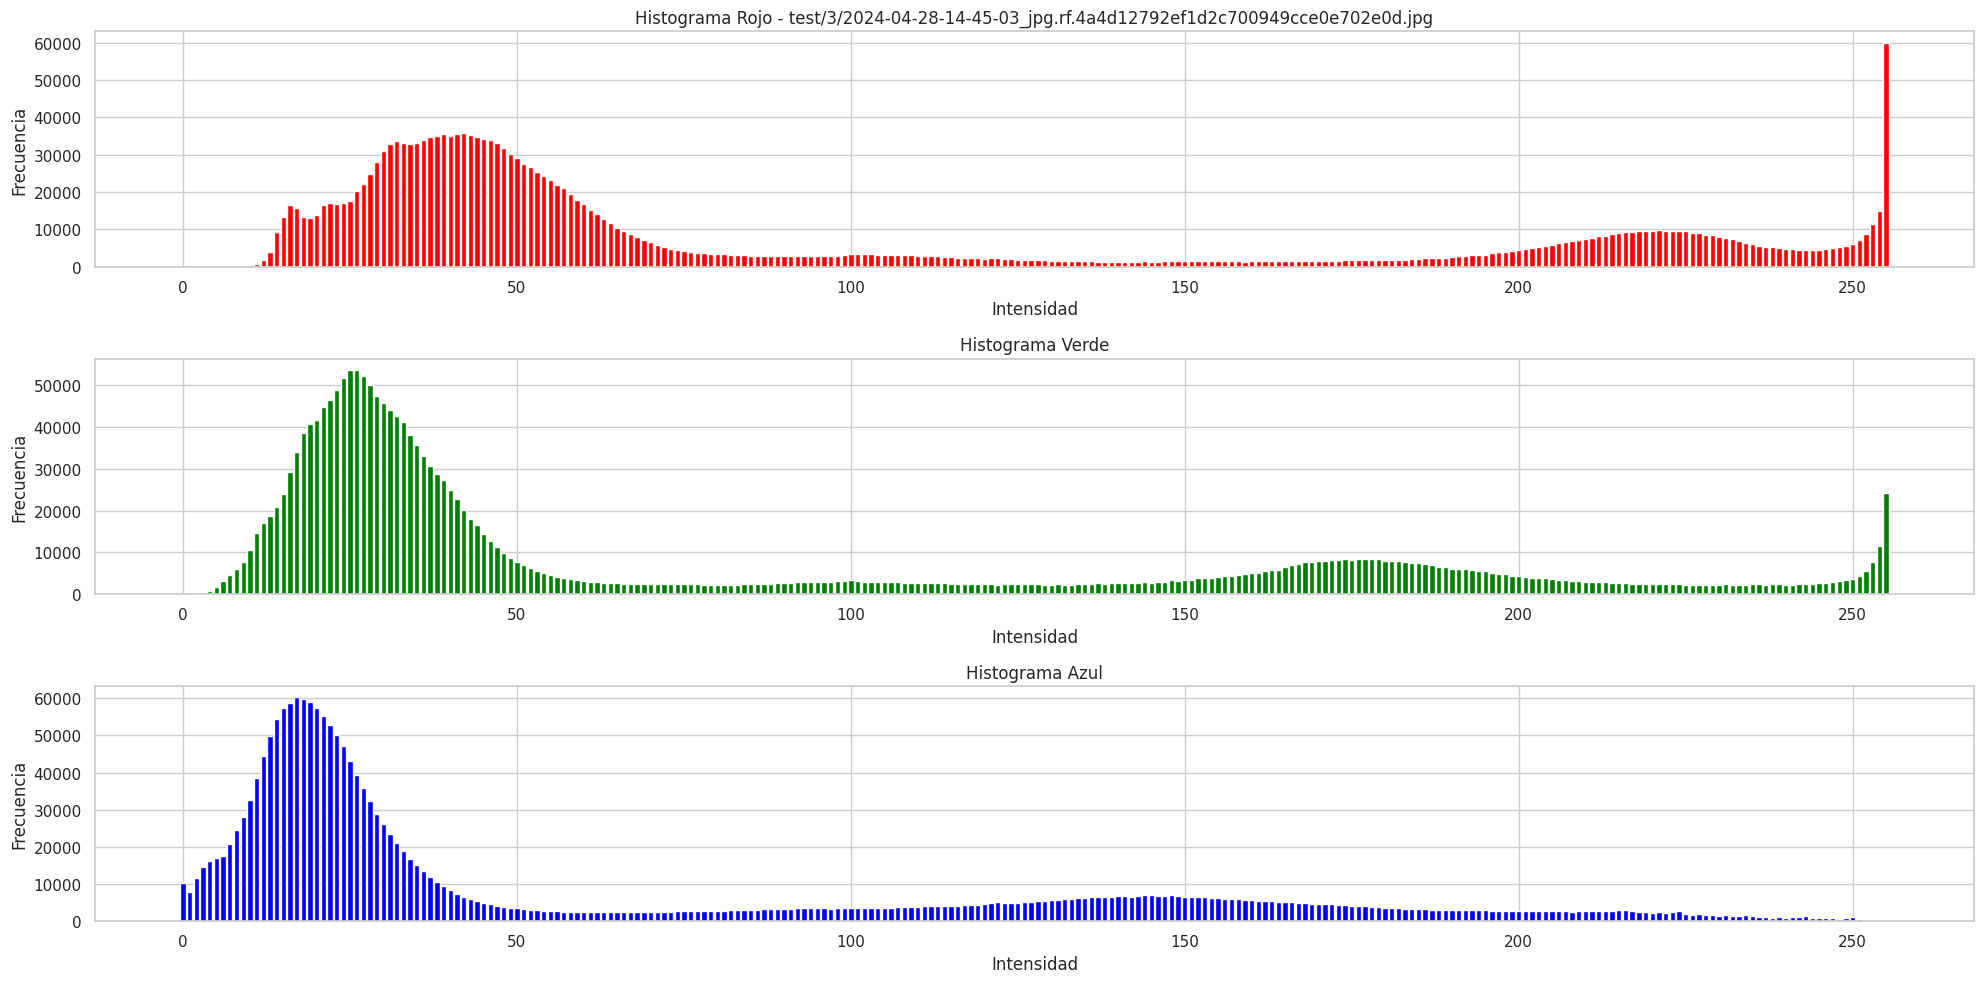

In [32]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen al azar
random_index = random.randint(0, len(df)-1)
image_row = df.iloc[random_index]

# Extraer los histogramas
hist_red = image_row['Histogram_Red']
hist_green = image_row['Histogram_Green']
hist_blue = image_row['Histogram_Blue']

# Crear los histogramas
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.bar(range(256), hist_red, color='red')
plt.title(f"Histograma Rojo - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.bar(range(256), hist_green, color='green')
plt.title("Histograma Verde")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.bar(range(256), hist_blue, color='blue')
plt.title("Histograma Azul")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Sobreponemos los 3 histogramas

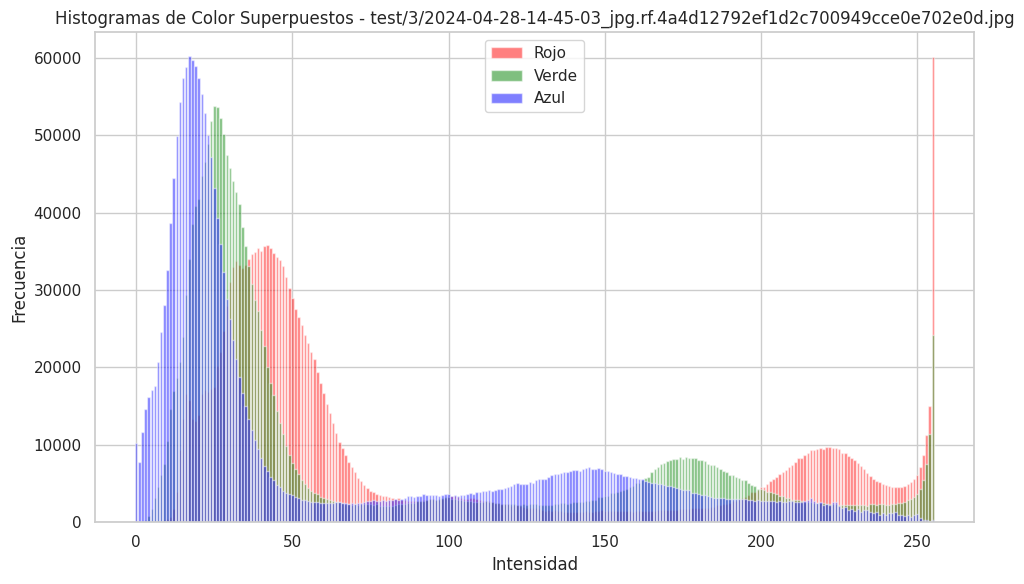

In [33]:
import matplotlib.pyplot as plt

# Crear una sola gráfica con los tres histogramas superpuestos
plt.figure(figsize=(10, 6))

plt.bar(range(256), hist_red, color='red', alpha=0.5, label='Rojo')
plt.bar(range(256), hist_green, color='green', alpha=0.5, label='Verde')
plt.bar(range(256), hist_blue, color='blue', alpha=0.5, label='Azul')

plt.title(f"Histogramas de Color Superpuestos - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


### Creamos el histograma promedio de todo el dataset 

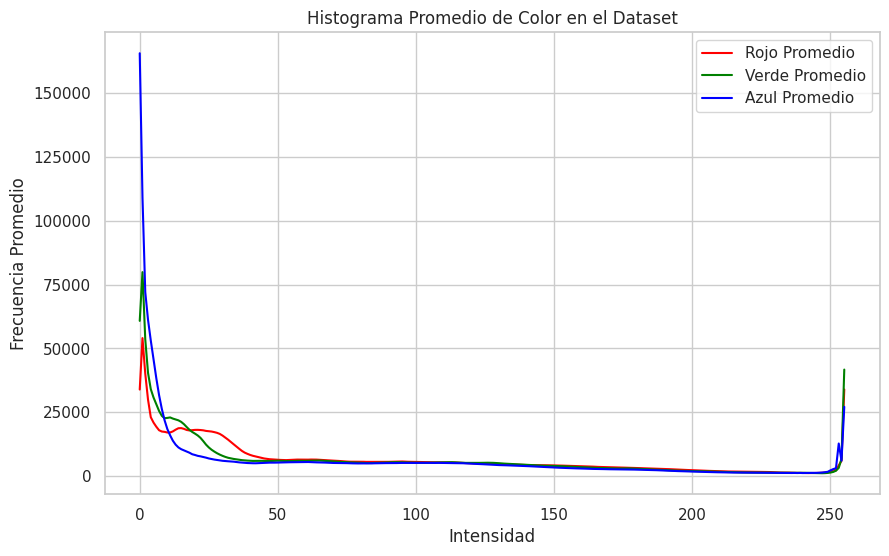

In [34]:
import numpy as np

# Inicializar arrays para acumular los histogramas
accum_hist_red = np.zeros(256)
accum_hist_green = np.zeros(256)
accum_hist_blue = np.zeros(256)

# Acumular los histogramas de todas las imágenes
for idx, row in df.iterrows():
    accum_hist_red += np.array(row['Histogram_Red'])
    accum_hist_green += np.array(row['Histogram_Green'])
    accum_hist_blue += np.array(row['Histogram_Blue'])

# Calcular los histogramas promedio
num_images = len(df)
avg_hist_red = accum_hist_red / num_images
avg_hist_green = accum_hist_green / num_images
avg_hist_blue = accum_hist_blue / num_images

# Graficar los histogramas promedio
plt.figure(figsize=(10, 6))
plt.plot(range(256), avg_hist_red, color='red', label='Rojo Promedio')
plt.plot(range(256), avg_hist_green, color='green', label='Verde Promedio')
plt.plot(range(256), avg_hist_blue, color='blue', label='Azul Promedio')
plt.title('Histograma Promedio de Color en el Dataset')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia Promedio')
plt.legend()
plt.show()


### Graficamos la luminosidad y el contraste de las imágenes en el dataset

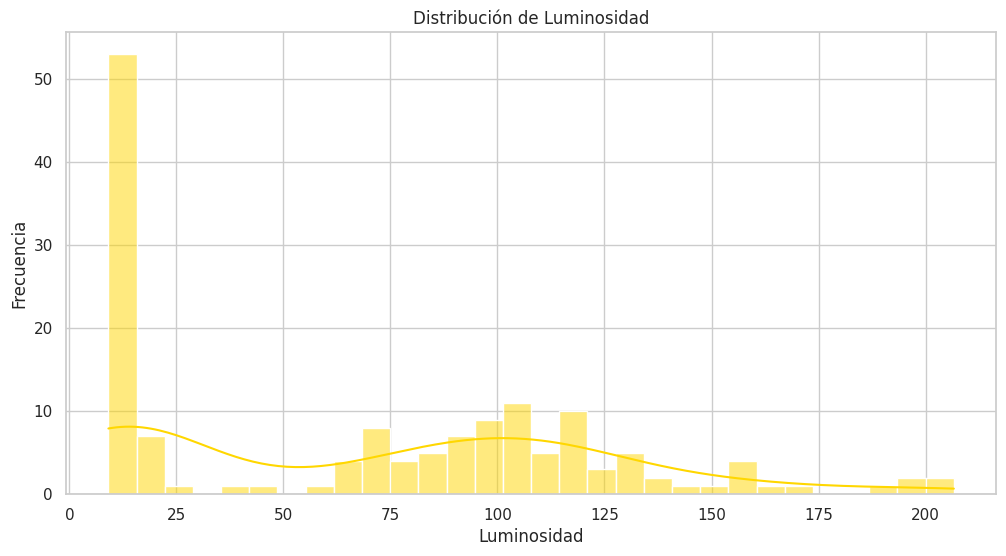

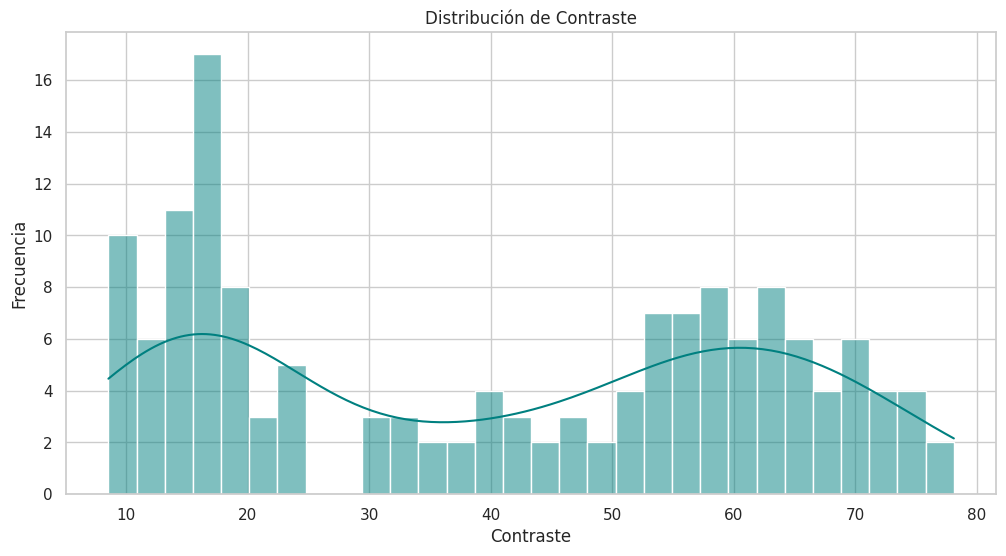

In [35]:
# Graficar la distribución de Luminosidad
plt.figure(figsize=(12, 6))
sns.histplot(df['Luminosity'], bins=30, kde=True, color='gold')
plt.title('Distribución de Luminosidad')
plt.xlabel('Luminosidad')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de Contraste
plt.figure(figsize=(12, 6))
sns.histplot(df['Contrast'], bins=30, kde=True, color='teal')
plt.title('Distribución de Contraste')
plt.xlabel('Contraste')
plt.ylabel('Frecuencia')
plt.show()


### Vemos el promedio de luminosidad en el dataset

In [36]:
print(df['Luminosity'].describe())


count    150.000000
mean      69.950024
std       54.077991
min        9.118111
25%       13.953170
50%       73.874065
75%      107.962451
max      206.610320
Name: Luminosity, dtype: float64


### Dividimos el dataset en cuantiles para tener 25%, 50% y 75%

In [37]:
# Calcular los cuartiles de la luminosidad
q1 = df['Luminosity'].quantile(0.25)
q3 = df['Luminosity'].quantile(0.75)
median_luminosity = df['Luminosity'].median()

print(f"Q1 (25%): {q1}")
print(f"Mediana (50%): {median_luminosity}")
print(f"Q3 (75%): {q3}")


Q1 (25%): 13.953169728973766
Mediana (50%): 73.87406539351852
Q3 (75%): 107.96245141300155


### Filtramos las imágenes según la cateroría de luminosidad, q1, q2 y q3

In [38]:
# Definir los rangos de luminosidad
luminosity_low_max = q1
luminosity_average_min = q1
luminosity_average_max = q3
luminosity_high_min = q3

# Filtrar imágenes por categoría
low_luminosity_df = df[df['Luminosity'] <= luminosity_low_max]
average_luminosity_df = df[(df['Luminosity'] > luminosity_average_min) & (df['Luminosity'] <= luminosity_average_max)]
high_luminosity_df = df[df['Luminosity'] > luminosity_high_min]

# Verificar el número de imágenes en cada categoría
print(f"Número de imágenes con baja luminosidad: {len(low_luminosity_df)}")
print(f"Número de imágenes con luminosidad promedio: {len(average_luminosity_df)}")
print(f"Número de imágenes con alta luminosidad: {len(high_luminosity_df)}")


Número de imágenes con baja luminosidad: 38
Número de imágenes con luminosidad promedio: 74
Número de imágenes con alta luminosidad: 38


### Función para descargar una imagen del s3 según la key

In [39]:
def download_image_from_s3(s3_client, bucket, key):
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Convertir a RGB si es necesario
        return image
    except Exception as e:
        print(f"Error al descargar o procesar la imagen {key}: {e}")
        return None


### Función para descargar 3 imágenes del s3 según las 3 categorías

In [40]:
# Función para seleccionar una imagen al azar de un DataFrame
def select_random_image(df_category):
    if df_category.empty:
        print("No hay imágenes en esta categoría.")
        return None
    return df_category.sample(n=1).iloc[0]

# Seleccionar una imagen de cada categoría
image_low = select_random_image(low_luminosity_df)
image_average = select_random_image(average_luminosity_df)
image_high = select_random_image(high_luminosity_df)


### Descargamos las 3 imágenes

In [41]:
# Inicializar el cliente de S3
s3 = boto3.client('s3')

# Descargar las imágenes
image_low_pil = download_image_from_s3(s3, BUCKET_NAME, image_low['Key']) if image_low is not None else None
image_average_pil = download_image_from_s3(s3, BUCKET_NAME, image_average['Key']) if image_average is not None else None
image_high_pil = download_image_from_s3(s3, BUCKET_NAME, image_high['Key']) if image_high is not None else None


### Mostramos las 3 imágenes, una para cada nivel de luminosidad

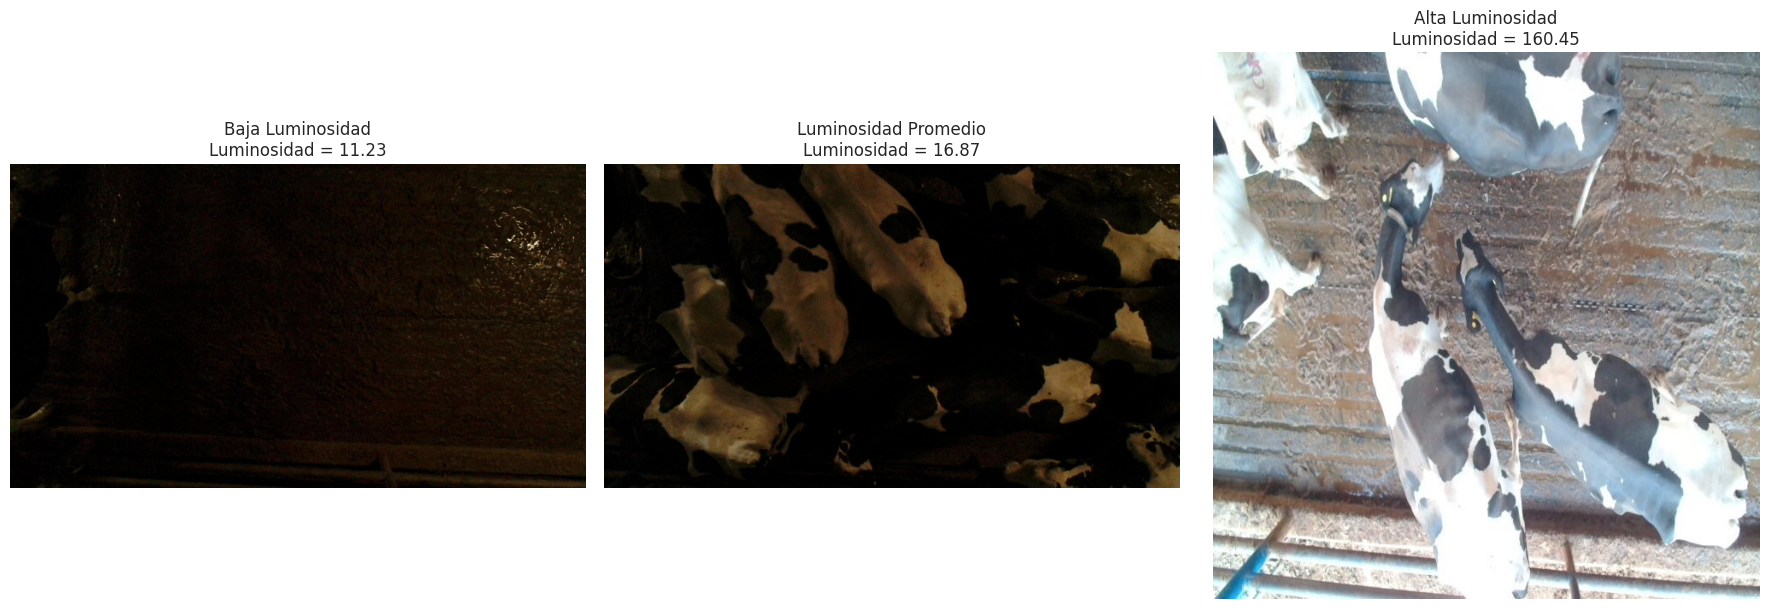

In [42]:
# Crear una figura con 3 subplots
plt.figure(figsize=(18, 6))

# Imagen de baja luminosidad
plt.subplot(1, 3, 1)
if image_low_pil:
    plt.imshow(image_low_pil)
    plt.title(f'Baja Luminosidad\nLuminosidad = {image_low["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de luminosidad promedio
plt.subplot(1, 3, 2)
if image_average_pil:
    plt.imshow(image_average_pil)
    plt.title(f'Luminosidad Promedio\nLuminosidad = {image_average["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de alta luminosidad
plt.subplot(1, 3, 3)
if image_high_pil:
    plt.imshow(image_high_pil)
    plt.title(f'Alta Luminosidad\nLuminosidad = {image_high["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

plt.tight_layout()
plt.show()